## 0 - Imports

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error as mae, r2_score
def rmse(true,pred):
    return np.sqrt(mean_squared_error(true,pred))

import joblib


### 0.1- My functions

In [3]:
class dfTransformer():
  def __init__(self,func):
    self.func=func
  
  def transform(self,df):
    return self.func(df)

  def fit(self, X, y=None):
    return self
    
def to_float(x):
    try:
        return abs(float(x))
    except:        
        return abs(float(x.replace('.','',1)))

def data_transformer(df):
    df.BestSquatKg = df.BestSquatKg.apply(to_float)
    df.Sex = df.Sex.map({'M':1, 'F':0})
    return df

## 1 - Look at Data

In [4]:
raw_df = pd.read_csv('data/lifting.csv')
raw_df.head(3)

,Name,Sex,Equipment,Age,BodyweightKg,BestSquatKg,BestDeadliftKg,BestBenchKg
0,Carlos Ceron,M,Raw,23.0,87.30,205.0,235.0,125.0
1,Tito Herrera,M,Wraps,23.0,73.48,220.0,260.0,157.5
2,Levi Lehman,M,Raw,26.0,112.40,142.5,220.0,145.0


In [5]:
print(raw_df.dtypes)

Name               object
Sex                object
Equipment          object
Age               float64
BodyweightKg      float64
BestSquatKg        object
BestDeadliftKg    float64
BestBenchKg       float64
dtype: object


In [6]:
print(raw_df.shape)

(30000, 8)


In [26]:
print(raw_df.isnull().sum())

Name                0
Sex                 0
Equipment           0
Age               420
BodyweightKg        0
BestSquatKg         0
BestDeadliftKg      0
BestBenchKg         0
dtype: int64


In [27]:
cat_uniques= [feature for feature in raw_df.columns if raw_df[feature].nunique() <6]
print(f'Possible categorical features ({len(cat_uniques)}) - nunique<6:{cat_uniques}')

Possible categorical features (2) - nunique<6:['Sex', 'Equipment']


### 1.1 - Wrong data:
* BestSquatKg shouldn't be object type
* 420 missing ages
* Categorical cols as object

## 2 - Processing data

In [62]:
df1 = raw_df.copy()

### 2.1 - SquatKg to float

In [63]:
# df1.BestSquatKg.astype('float')

def to_float(x):
    try:
        return abs(float(x))
    except:        
        return abs(float(x.replace('.','',1)))

df1.BestSquatKg = df1.BestSquatKg.apply(to_float)
df1.dtypes

Name               object
Sex                object
Equipment          object
Age               float64
BodyweightKg      float64
BestSquatKg       float64
BestDeadliftKg    float64
BestBenchKg       float64
dtype: object

### 2.2 Categorical cols

In [64]:
cat_info =dict()
for col in cat_uniques:
    codes, categories = df1[col].factorize()
    df1[col] = codes
    cat_info[col] = list(categories)
print(cat_info)
df1.head()

{'Sex': ['M', 'F'], 'Equipment': ['Raw', 'Wraps', 'Single-ply', 'Multi-ply']}


,Name,Sex,Equipment,Age,BodyweightKg,BestSquatKg,BestDeadliftKg,BestBenchKg
0,Carlos Ceron,0,0,23.0,87.30,205.0,235.0,125.0
1,Tito Herrera,0,1,23.0,73.48,220.0,260.0,157.5
2,Levi Lehman,0,0,26.0,112.40,142.5,220.0,145.0
3,Stacy Hayford,1,0,35.0,59.42,95.0,102.5,60.0
4,Brittany Hirt,1,0,26.5,61.40,105.0,127.5,60.0


### 2.3 - Missing ages

In [59]:

age_imputer = IterativeImputer()
after_impute = age_imputer.fit_transform(df1.drop(['Name', 'BestBenchKg'], axis=1))
display(after_impute)
pd.DataFrame(after_impute).isnull().sum()

array([[  0.  ,   0.  ,  23.  ,  87.3 , 205.  , 235.  ],
       [  0.  ,   1.  ,  23.  ,  73.48, 220.  , 260.  ],
       [  0.  ,   0.  ,  26.  , 112.4 , 142.5 , 220.  ],
       ...,
       [  0.  ,   0.  ,  22.5 ,  82.62, 250.  , 311.  ],
       [  1.  ,   1.  ,  28.  ,  74.3 , 105.  , 152.5 ],
       [  1.  ,   0.  ,  22.  ,  55.8 , 105.  , 145.  ]])

0    0
1    0
2    0
3    0
4    0
5    0
dtype: int64

### 2.4 Negative Values

In [87]:
for col in ['BestBenchKg', 'BestSquatKg']:
    df1[col] = abs(df1[col])
    
df1.describe()

,Sex,Equipment,Age,BodyweightKg,BestSquatKg,BestDeadliftKg,BestBenchKg
count,30000.000000,30000.000000,29580.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,0.323067,0.505333,29.678786,85.359097,179.229005,201.114296,116.957666
std,0.467656,0.774806,11.576102,22.881926,69.306289,62.369995,51.342817
min,0.000000,0.000000,7.000000,24.100000,13.600000,18.100000,9.100000
25%,0.000000,0.000000,21.500000,68.050000,125.000000,147.500000,72.500000
50%,0.000000,0.000000,26.500000,82.100000,175.000000,204.120000,115.000000
75%,1.000000,1.000000,35.000000,98.880000,222.500000,247.500000,150.000000
max,1.000000,3.000000,89.500000,242.400000,532.970000,420.500000,425.000000


## 3 - Exploratoring Data

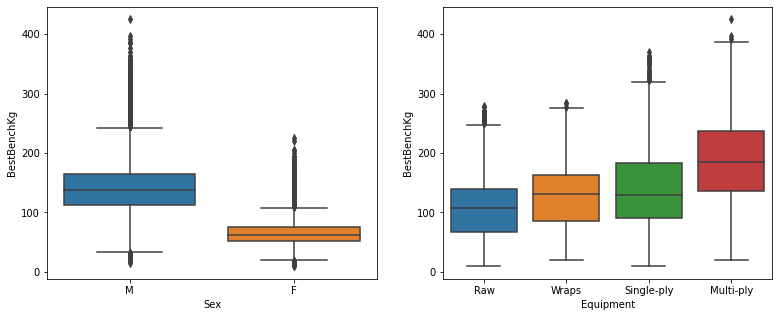

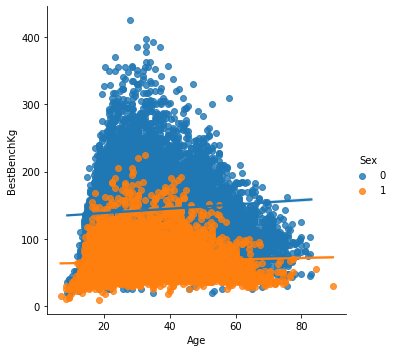

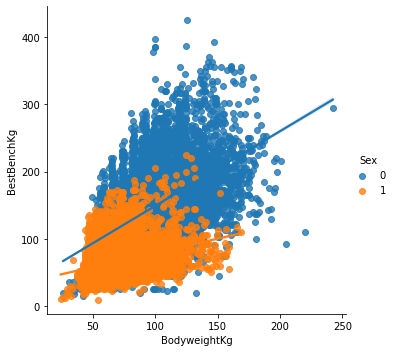

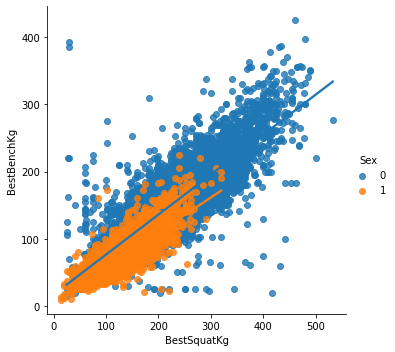

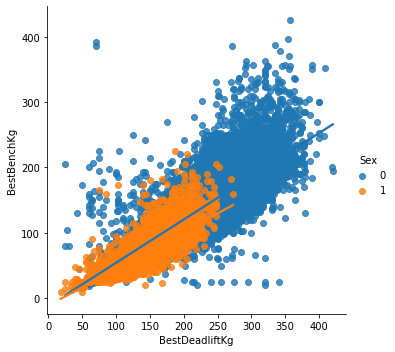

In [88]:
plt.figure(figsize=(13,5))
for i,col in enumerate(cat_uniques):
    plt.subplot(1,2,i+1)
    sns.boxplot(x=df1[col], y=df1['BestBenchKg'])
    plt.xticks(range(len(cat_info[col])), cat_info[col])
plt.show()

for col in ['Age', 'BodyweightKg', 'BestSquatKg','BestDeadliftKg']:
    sns.lmplot(x=col, y = 'BestBenchKg', data=df1, hue='Sex')


## 4 - Preparing for ML

### 4.1 Steps for pipeline
* Convert wrong type to float
* Map sex
* OHE equipament
* Inpute missing values
* Scale numeric values

In [89]:
def data_transformer(df):
    df.BestSquatKg = df.BestSquatKg.apply(to_float)
    df.Sex = df.Sex.map({'M':1, 'F':0})
    return df

In [90]:
numeric_transformer = make_pipeline(age_imputer,StandardScaler())
ohe = OneHotEncoder(handle_unknown='ignore')
num_cols = ['Age','BodyweightKg', 'BestSquatKg','BestDeadliftKg']
transformer = make_column_transformer(
    (ohe,['Equipment']),
    (numeric_transformer, num_cols),
    remainder='passthrough'
)

## 5 - Machine Learning

### 5.1 - Spliting data

In [91]:
X = raw_df.drop(['Name', 'BestBenchKg'], axis =1)
y= abs(raw_df.BestBenchKg)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_test.shape)
X.head(2)

(24000, 6) (6000,)


,Sex,Equipment,Age,BodyweightKg,BestSquatKg,BestDeadliftKg
0,M,Raw,23.0,87.30,205.0,235.0
1,M,Wraps,23.0,73.48,220.0,260.0


### 5.2 Model list

In [93]:
model_list = [RandomForestRegressor(), LGBMRegressor(), XGBRegressor()]

In [94]:
for model in model_list:
    X = raw_df.drop(['Name', 'BestBenchKg'], axis =1)
    y= y= abs(raw_df.BestBenchKg)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    pipe = make_pipeline(
        dfTransformer(data_transformer),
        transformer,
        model        
    )
    pipe.fit(X_train,y_train)
    pred = pipe.predict(X_test)
    print(list(pipe.named_steps)[2].capitalize())
    print(f'RMSE: {rmse(y_test,pred)}')
    print(f'MAE: {mae(y_test,pred)}')
    print(f'R2: {r2_score(y_test,pred)}')
    print('---------------------------------------------')
    

Randomforestregressor
RMSE: 18.030917065690073
MAE: 12.871106427500001
R2: 0.8775354330798311
---------------------------------------------
Lgbmregressor
RMSE: 17.459536074662616
MAE: 12.536473124856437
R2: 0.8851740046436584
---------------------------------------------
Xgbregressor
RMSE: 17.99341022634088
MAE: 12.783030254707336
R2: 0.8780443901682641
---------------------------------------------


### 5.3 Escolhendo o LGBMRegressor

In [95]:
final_model = make_pipeline(
        dfTransformer(data_transformer),
        transformer,
        LGBMRegressor()        
    )
X = raw_df.drop(['Name', 'BestBenchKg'], axis =1)
y= abs(raw_df.BestBenchKg)

final_model.fit(X,y)

Pipeline(steps=[('dftransformer',
                 <__main__.dfTransformer object at 0x000001D65B3B2430>),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Equipment']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('iterativeimputer',
                                                                   IterativeImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'BodyweightKg',
                                                   'BestSquatKg',
                      

## 6 - Exporting model

In [96]:
joblib.dump(final_model,'models/lgbm_v1.pkl')

['models/lgbm_v1.pkl']